<a href="https://www.kaggle.com/code/avnigupta29092003/predict-diabetic-retinopathy-with-dl-fdc8ea?scriptVersionId=153571830" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [14]:
image_dir = Path('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [15]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(10)

Filepath           Label
0  ../input/diabetic-retinopathy-224x224-gaussian...           No_DR
1  ../input/diabetic-retinopathy-224x224-gaussian...  Proliferate_DR
2  ../input/diabetic-retinopathy-224x224-gaussian...        Moderate
3  ../input/diabetic-retinopathy-224x224-gaussian...            Mild
4  ../input/diabetic-retinopathy-224x224-gaussian...          Severe
5  ../input/diabetic-retinopathy-224x224-gaussian...  Proliferate_DR
6  ../input/diabetic-retinopathy-224x224-gaussian...        Moderate
7  ../input/diabetic-retinopathy-224x224-gaussian...        Moderate
8  ../input/diabetic-retinopathy-224x224-gaussian...            Mild
9  ../input/diabetic-retinopathy-224x224-gaussian...           No_DR

## Visualization

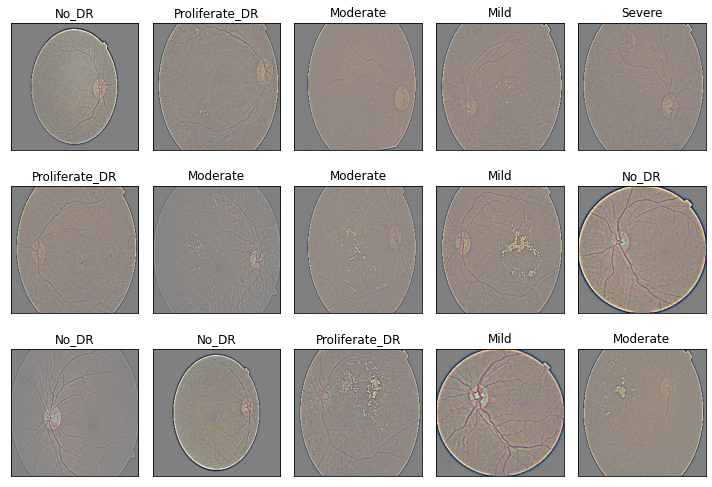

In [16]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [17]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

In [18]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [19]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [20]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [21]:
# Dictionary with the models
models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
   
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 51s 402ms/step - loss: 0.9483 - accuracy: 0.6516 - val_loss: 0.6233 - val_accuracy: 0.7751
DenseNet201          trained in 51.55 sec
93/93 [==============================] - 18s 156ms/step - loss: 1.1139 - accuracy: 0.5779 - val_loss: 0.8530 - val_accuracy: 0.7052
ResNet50             trained in 18.17 sec
93/93 [==============================] - 16s 160ms/step - loss: 1.1333 - accuracy: 0.5945 - val_loss: 0.8186 - val_accuracy: 0.7052
VGG19                trained in 16.4 sec


In [22]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0  DenseNet201          0.7178        0.7751                51.55
1     ResNet50          0.6416        0.7052                18.17
2        VGG19          0.6608        0.7052                16.40

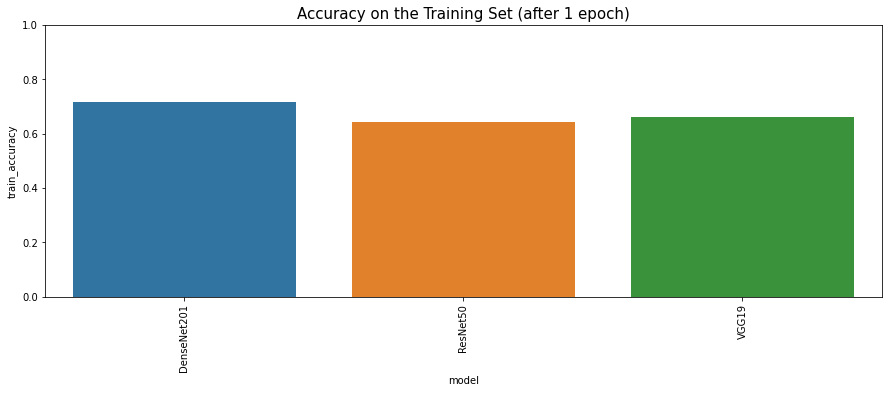

In [23]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

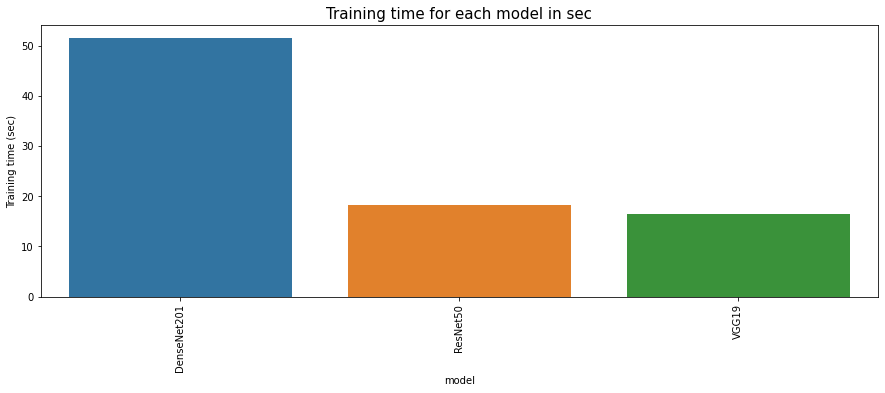

In [25]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 3. DENSENET201<a class="anchor" id="4"></a>

In [26]:
# Load the pretained model
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [27]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 27s 181ms/step - loss: 0.9574 - accuracy: 0.6679 - val_loss: 0.6254 - val_accuracy: 0.7660
Epoch 2/10
93/93 [==============================] - 14s 150ms/step - loss: 0.6228 - accuracy: 0.7720 - val_loss: 0.7371 - val_accuracy: 0.7568
Epoch 3/10
93/93 [==============================] - 15s 159ms/step - loss: 0.6262 - accuracy: 0.7670 - val_loss: 0.5448 - val_accuracy: 0.7872
Epoch 4/10
93/93 [==============================] - 14s 154ms/step - loss: 0.5410 - accuracy: 0.7974 - val_loss: 0.5068 - val_accuracy: 0.8055
Epoch 5/10
93/93 [==============================] - 14s 149ms/step - loss: 0.5268 - accuracy: 0.8026 - val_loss: 0.5272 - val_accuracy: 0.7842
Epoch 6/10
93/93 [==============================] - 14s 147ms/step - loss: 0.5031 - accuracy: 0.8071 - val_loss: 0.4957 - val_accuracy: 0.8055
Epoch 7/10
93/93 [==============================] - 14s 149ms/step - loss: 0.4828 - accuracy: 0.8155 - val_loss: 0.5416 - val_accuracy: 0.7629

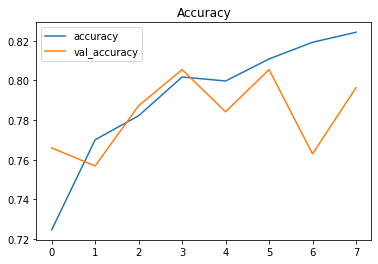

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Visualize the result<a class="anchor" id="5"></a>

In [30]:
results = model.evaluate(test_images, verbose=0)

In [31]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.62384

## Accuracy on the test set: 76.84%

In [32]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['No_DR', 'No_DR', 'No_DR', 'Moderate', 'Moderate']


In [33]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.60      0.50      0.55        42
      Moderate       0.60      0.78      0.68        91
         No_DR       0.96      0.97      0.96       179
Proliferate_DR       0.46      0.38      0.42        29
        Severe       0.67      0.23      0.34        26

      accuracy                           0.77       367
     macro avg       0.66      0.57      0.59       367
  weighted avg       0.77      0.77      0.76       367



In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [59]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 4. RESNET 50<a class="anchor" id="6"></a>

In [36]:
# Load the pretained model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [37]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 17s 151ms/step - loss: 1.1602 - accuracy: 0.5468 - val_loss: 0.8753 - val_accuracy: 0.6930
Epoch 2/10
93/93 [==============================] - 14s 145ms/step - loss: 0.9340 - accuracy: 0.6621 - val_loss: 0.8569 - val_accuracy: 0.6960
Epoch 3/10
93/93 [==============================] - 13s 143ms/step - loss: 0.8591 - accuracy: 0.6856 - val_loss: 0.8552 - val_accuracy: 0.7173
Epoch 4/10
93/93 [==============================] - 13s 141ms/step - loss: 0.8634 - accuracy: 0.6845 - val_loss: 0.8180 - val_accuracy: 0.7143
Epoch 5/10
93/93 [==============================] - 13s 143ms/step - loss: 0.8103 - accuracy: 0.7052 - val_loss: 0.7999 - val_accuracy: 0.7204
Epoch 6/10
93/93 [==============================] - 13s 141ms/step - loss: 0.8137 - accuracy: 0.7031 - val_loss: 0.7879 - val_accuracy: 0.7264
Epoch 7/10
93/93 [==============================] - 14s 149ms/step - loss: 0.7861 - accuracy: 0.7170 - val_loss: 0.7825 - val_accuracy: 0.7143

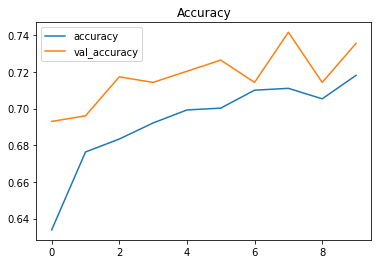

In [38]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

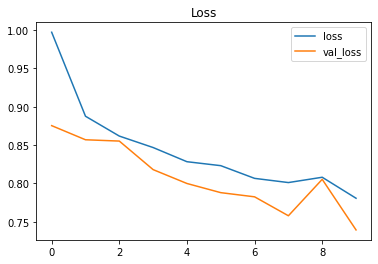

In [39]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [40]:
results = model.evaluate(test_images, verbose=0)

In [41]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.85784

## Accuracy on the test set: 67.03%

In [42]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['No_DR', 'Moderate', 'No_DR', 'Moderate', 'Moderate']


In [43]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.50      0.17      0.25        42
      Moderate       0.46      0.85      0.60        91
         No_DR       0.87      0.91      0.89       179
Proliferate_DR       0.00      0.00      0.00        29
        Severe       0.00      0.00      0.00        26

      accuracy                           0.67       367
     macro avg       0.37      0.38      0.35       367
  weighted avg       0.60      0.67      0.61       367



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


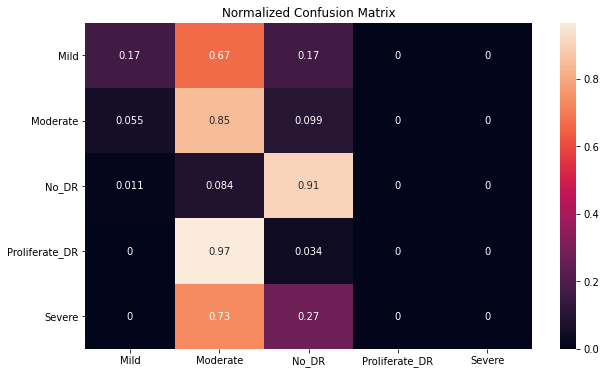

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

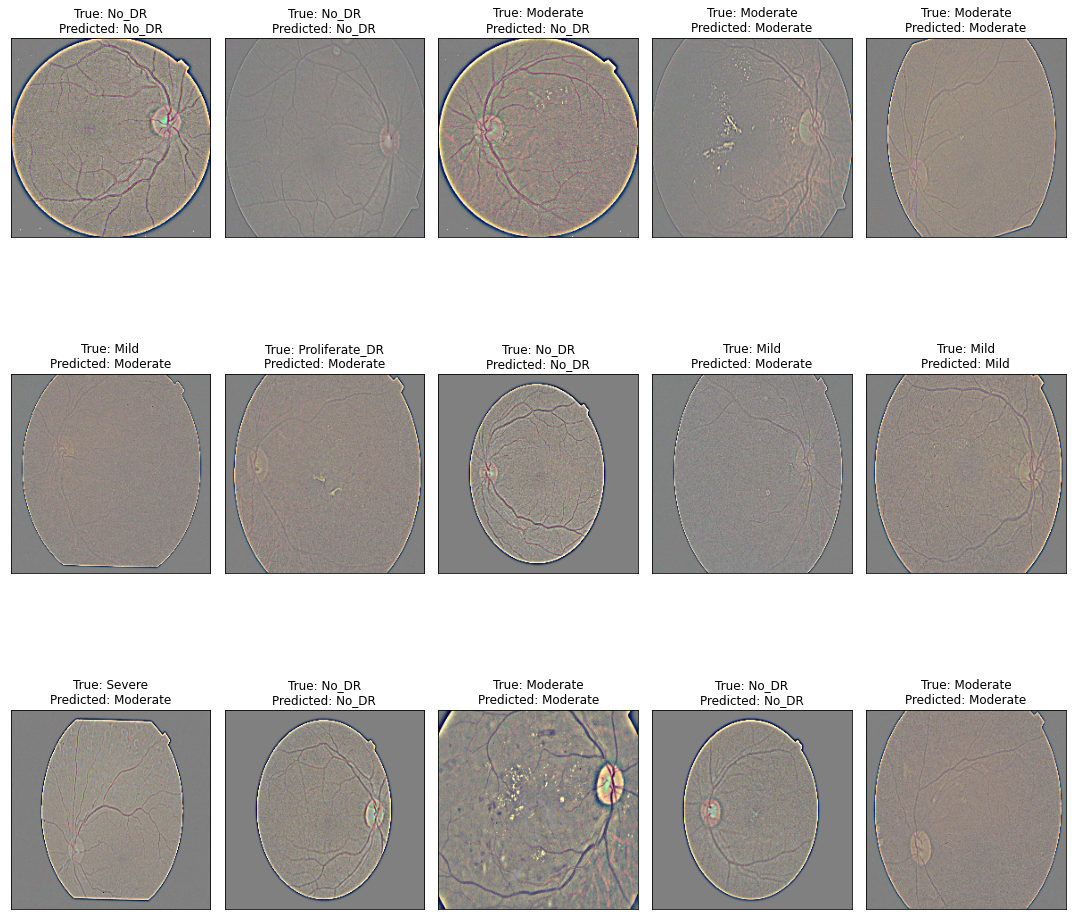

In [62]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 5. VGG19<a class="anchor" id="7"></a>

In [46]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [47]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 14s 147ms/step - loss: 1.2123 - accuracy: 0.5463 - val_loss: 0.8184 - val_accuracy: 0.7204
Epoch 2/10
93/93 [==============================] - 14s 146ms/step - loss: 0.8253 - accuracy: 0.7116 - val_loss: 0.7469 - val_accuracy: 0.7477
Epoch 3/10
93/93 [==============================] - 13s 143ms/step - loss: 0.7590 - accuracy: 0.7330 - val_loss: 0.7328 - val_accuracy: 0.7356
Epoch 4/10
93/93 [==============================] - 13s 144ms/step - loss: 0.7748 - accuracy: 0.7168 - val_loss: 0.7394 - val_accuracy: 0.7386
Epoch 5/10
93/93 [==============================] - 14s 146ms/step - loss: 0.7308 - accuracy: 0.7327 - val_loss: 0.6724 - val_accuracy: 0.7386
Epoch 6/10
93/93 [==============================] - 14s 149ms/step - loss: 0.7181 - accuracy: 0.7339 - val_loss: 0.6863 - val_accuracy: 0.7386
Epoch 7/10
93/93 [==============================] - 14s 147ms/step - loss: 0.7043 - accuracy: 0.7505 - val_loss: 0.6945 - val_accuracy: 0.7447

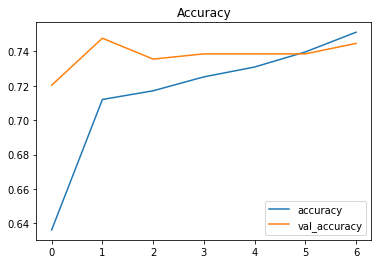

In [48]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [49]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [50]:
results = model.evaluate(test_images, verbose=0)

In [51]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.77399

## Accuracy on the test set: 69.48%

In [52]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['No_DR', 'No_DR', 'No_DR', 'Moderate', 'Moderate']


In [53]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.57      0.10      0.16        42
      Moderate       0.47      0.92      0.62        91
         No_DR       0.92      0.93      0.93       179
Proliferate_DR       0.00      0.00      0.00        29
        Severe       0.00      0.00      0.00        26

      accuracy                           0.69       367
     macro avg       0.39      0.39      0.34       367
  weighted avg       0.63      0.69      0.63       367



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


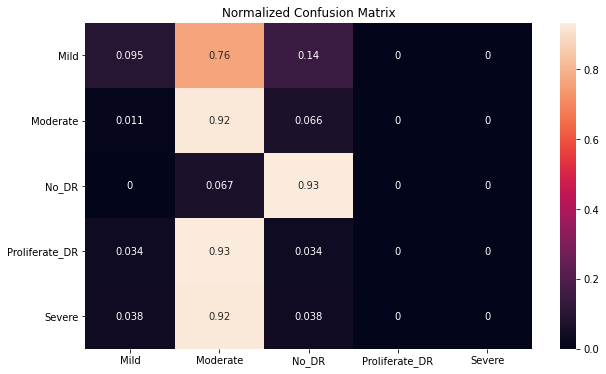

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

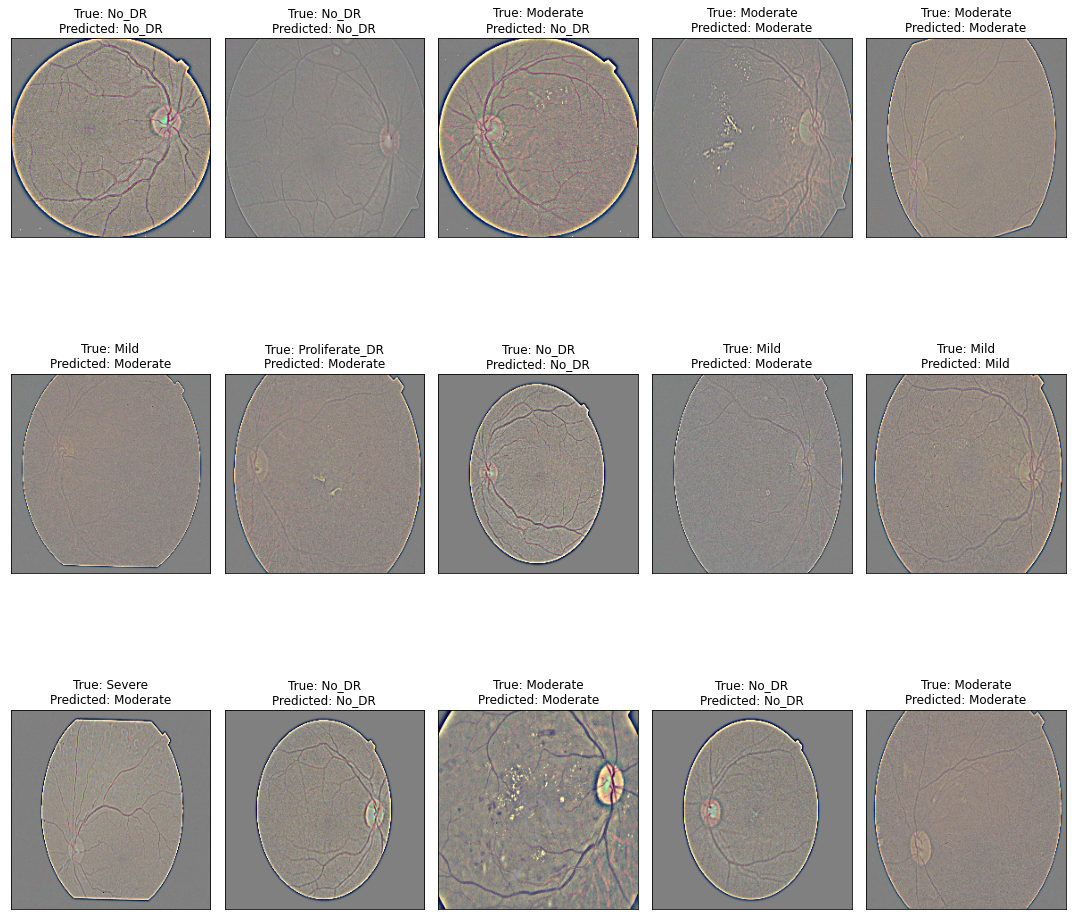

In [60]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [61]:
results = model.evaluate(test_images, verbose=0)
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.77399

## Accuracy on the test set: 69.48%